#Networks

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# Acknowledgement to
# https://github.com/kuangliu/pytorch-cifar,
# https://github.com/BIGBALLON/CIFAR-ZOO,


''' Swish activation '''
class Swish(nn.Module): # Swish(x) = x∗σ(x)
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return input * torch.sigmoid(input)


''' MLP '''
class MLP(nn.Module):
    def __init__(self, channel, num_classes):
        super(MLP, self).__init__()
        self.fc_1 = nn.Linear(28*28*1 if channel==1 else 32*32*3, 128)
        self.fc_2 = nn.Linear(128, 128)
        self.fc_3 = nn.Linear(128, num_classes)

    def forward(self, x):
        out = x.view(x.size(0), -1)
        out = F.relu(self.fc_1(out))
        out = F.relu(self.fc_2(out))
        out = self.fc_3(out)
        return out



''' ConvNet '''
class ConvNet(nn.Module):
    def __init__(self, channel, num_classes, net_width, net_depth, net_act, net_norm, net_pooling, im_size = (32,32)):
        super(ConvNet, self).__init__()

        self.features, shape_feat = self._make_layers(channel, net_width, net_depth, net_norm, net_act, net_pooling, im_size)
        num_feat = shape_feat[0]*shape_feat[1]*shape_feat[2]
        self.classifier = nn.Linear(num_feat, num_classes)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def embed(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        return out

    def _get_activation(self, net_act):
        if net_act == 'sigmoid':
            return nn.Sigmoid()
        elif net_act == 'relu':
            return nn.ReLU(inplace=True)
        elif net_act == 'leakyrelu':
            return nn.LeakyReLU(negative_slope=0.01)
        elif net_act == 'swish':
            return Swish()
        else:
            exit('unknown activation function: %s'%net_act)

    def _get_pooling(self, net_pooling):
        if net_pooling == 'maxpooling':
            return nn.MaxPool2d(kernel_size=2, stride=2)
        elif net_pooling == 'avgpooling':
            return nn.AvgPool2d(kernel_size=2, stride=2)
        elif net_pooling == 'none':
            return None
        else:
            exit('unknown net_pooling: %s'%net_pooling)

    def _get_normlayer(self, net_norm, shape_feat):
        # shape_feat = (c*h*w)
        if net_norm == 'batchnorm':
            return nn.BatchNorm2d(shape_feat[0], affine=True)
        elif net_norm == 'layernorm':
            return nn.LayerNorm(shape_feat, elementwise_affine=True)
        elif net_norm == 'instancenorm':
            return nn.GroupNorm(shape_feat[0], shape_feat[0], affine=True)
        elif net_norm == 'groupnorm':
            return nn.GroupNorm(4, shape_feat[0], affine=True)
        elif net_norm == 'none':
            return None
        else:
            exit('unknown net_norm: %s'%net_norm)

    def _make_layers(self, channel, net_width, net_depth, net_norm, net_act, net_pooling, im_size):
        layers = []
        in_channels = channel
        if im_size[0] == 28:
            im_size = (32, 32)
        shape_feat = [in_channels, im_size[0], im_size[1]]
        for d in range(net_depth):
            layers += [nn.Conv2d(in_channels, net_width, kernel_size=3, padding=3 if channel == 1 and d == 0 else 1)]
            shape_feat[0] = net_width
            if net_norm != 'none':
                layers += [self._get_normlayer(net_norm, shape_feat)]
            layers += [self._get_activation(net_act)]
            in_channels = net_width
            if net_pooling != 'none':
                layers += [self._get_pooling(net_pooling)]
                shape_feat[1] //= 2
                shape_feat[2] //= 2

        return nn.Sequential(*layers), shape_feat



''' LeNet '''
class LeNet(nn.Module):
    def __init__(self, channel, num_classes):
        super(LeNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(channel, 6, kernel_size=5, padding=2 if channel==1 else 0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_1 = nn.Linear(16 * 5 * 5, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x))
        x = self.fc_3(x)
        return x



''' AlexNet '''
class AlexNet(nn.Module):
    def __init__(self, channel, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(channel, 128, kernel_size=5, stride=1, padding=4 if channel==1 else 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Linear(192 * 4 * 4, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def embed(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return x


''' AlexNetBN '''
class AlexNetBN(nn.Module):
    def __init__(self, channel, num_classes):
        super(AlexNetBN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(channel, 128, kernel_size=5, stride=1, padding=4 if channel==1 else 2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Linear(192 * 4 * 4, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def embed(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return x


''' VGG '''
cfg_vgg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}
class VGG(nn.Module):
    def __init__(self, vgg_name, channel, num_classes, norm='instancenorm'):
        super(VGG, self).__init__()
        self.channel = channel
        self.features = self._make_layers(cfg_vgg[vgg_name], norm)
        self.classifier = nn.Linear(512 if vgg_name != 'VGGS' else 128, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def embed(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return x

    def _make_layers(self, cfg, norm):
        layers = []
        in_channels = self.channel
        for ic, x in enumerate(cfg):
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=3 if self.channel==1 and ic==0 else 1),
                           nn.GroupNorm(x, x, affine=True) if norm=='instancenorm' else nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)


def VGG11(channel, num_classes):
    return VGG('VGG11', channel, num_classes)
def VGG11BN(channel, num_classes):
    return VGG('VGG11', channel, num_classes, norm='batchnorm')
def VGG13(channel, num_classes):
    return VGG('VGG13', channel, num_classes)
def VGG16(channel, num_classes):
    return VGG('VGG16', channel, num_classes)
def VGG19(channel, num_classes):
    return VGG('VGG19', channel, num_classes)


''' ResNet_AP '''
# The conv(stride=2) is replaced by conv(stride=1) + avgpool(kernel_size=2, stride=2)

class BasicBlock_AP(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, norm='instancenorm'):
        super(BasicBlock_AP, self).__init__()
        self.norm = norm
        self.stride = stride
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=1, padding=1, bias=False) # modification
        self.bn1 = nn.GroupNorm(planes, planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.GroupNorm(planes, planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=1, bias=False),
                nn.AvgPool2d(kernel_size=2, stride=2), # modification
                nn.GroupNorm(self.expansion * planes, self.expansion * planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        if self.stride != 1: # modification
            out = F.avg_pool2d(out, kernel_size=2, stride=2)
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck_AP(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, norm='instancenorm'):
        super(Bottleneck_AP, self).__init__()
        self.norm = norm
        self.stride = stride
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.GroupNorm(planes, planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False) # modification
        self.bn2 = nn.GroupNorm(planes, planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.GroupNorm(self.expansion * planes, self.expansion * planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=1, bias=False),
                nn.AvgPool2d(kernel_size=2, stride=2),  # modification
                nn.GroupNorm(self.expansion * planes, self.expansion * planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        if self.stride != 1: # modification
            out = F.avg_pool2d(out, kernel_size=2, stride=2)
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet_AP(nn.Module):
    def __init__(self, block, num_blocks, channel=3, num_classes=10, norm='instancenorm'):
        super(ResNet_AP, self).__init__()
        self.in_planes = 64
        self.norm = norm

        self.conv1 = nn.Conv2d(channel, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.GroupNorm(64, 64, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.classifier = nn.Linear(512 * block.expansion * 3 * 3 if channel==1 else 512 * block.expansion * 4 * 4, num_classes)  # modification

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, self.norm))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, kernel_size=1, stride=1) # modification
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def embed(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, kernel_size=1, stride=1) # modification
        out = out.view(out.size(0), -1)
        return out

def ResNet18BN_AP(channel, num_classes):
    return ResNet_AP(BasicBlock_AP, [2,2,2,2], channel=channel, num_classes=num_classes, norm='batchnorm')

def ResNet18_AP(channel, num_classes):
    return ResNet_AP(BasicBlock_AP, [2,2,2,2], channel=channel, num_classes=num_classes)


''' ResNet '''

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, norm='instancenorm'):
        super(BasicBlock, self).__init__()
        self.norm = norm
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.GroupNorm(planes, planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.GroupNorm(planes, planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.GroupNorm(self.expansion*planes, self.expansion*planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, norm='instancenorm'):
        super(Bottleneck, self).__init__()
        self.norm = norm
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.GroupNorm(planes, planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.GroupNorm(planes, planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.GroupNorm(self.expansion*planes, self.expansion*planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.GroupNorm(self.expansion*planes, self.expansion*planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, channel=3, num_classes=10, norm='instancenorm'):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.norm = norm

        self.conv1 = nn.Conv2d(channel, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.GroupNorm(64, 64, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.classifier = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, self.norm))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def embed(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        return out


def ResNet18BN(channel, num_classes):
    return ResNet(BasicBlock, [2,2,2,2], channel=channel, num_classes=num_classes, norm='batchnorm')

def ResNet18(channel, num_classes):
    return ResNet(BasicBlock, [2,2,2,2], channel=channel, num_classes=num_classes)

def ResNet34(channel, num_classes):
    return ResNet(BasicBlock, [3,4,6,3], channel=channel, num_classes=num_classes)

def ResNet50(channel, num_classes):
    return ResNet(Bottleneck, [3,4,6,3], channel=channel, num_classes=num_classes)

def ResNet101(channel, num_classes):
    return ResNet(Bottleneck, [3,4,23,3], channel=channel, num_classes=num_classes)

def ResNet152(channel, num_classes):
    return ResNet(Bottleneck, [3,8,36,3], channel=channel, num_classes=num_classes)

#Utils

In [2]:
import time
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from scipy.ndimage.interpolation import rotate as scipyrotate
#from networks import MLP, ConvNet, LeNet, AlexNet, AlexNetBN, VGG11, VGG11BN, ResNet18, ResNet18BN_AP, ResNet18BN

def get_dataset(dataset, data_path):
    if dataset == 'MNIST':
        channel = 1
        im_size = (28, 28)
        num_classes = 10
        mean = [0.1307]
        std = [0.3081]
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])
        dst_train = datasets.MNIST(data_path, train=True, download=True, transform=transform) # no augmentation
        dst_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)
        class_names = [str(c) for c in range(num_classes)]

    elif dataset == 'FashionMNIST':
        channel = 1
        im_size = (28, 28)
        num_classes = 10
        mean = [0.2861]
        std = [0.3530]
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])
        dst_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transform) # no augmentation
        dst_test = datasets.FashionMNIST(data_path, train=False, download=True, transform=transform)
        class_names = dst_train.classes

    elif dataset == 'SVHN':
        channel = 3
        im_size = (32, 32)
        num_classes = 10
        mean = [0.4377, 0.4438, 0.4728]
        std = [0.1980, 0.2010, 0.1970]
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])
        dst_train = datasets.SVHN(data_path, split='train', download=True, transform=transform)  # no augmentation
        dst_test = datasets.SVHN(data_path, split='test', download=True, transform=transform)
        class_names = [str(c) for c in range(num_classes)]

    elif dataset == 'CIFAR10':
        channel = 3
        im_size = (32, 32)
        num_classes = 10
        mean = [0.4914, 0.4822, 0.4465]
        std = [0.2023, 0.1994, 0.2010]
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])
        dst_train = datasets.CIFAR10(data_path, train=True, download=True, transform=transform) # no augmentation
        dst_test = datasets.CIFAR10(data_path, train=False, download=True, transform=transform)
        class_names = dst_train.classes

    elif dataset == 'CIFAR100':
        channel = 3
        im_size = (32, 32)
        num_classes = 100
        mean = [0.5071, 0.4866, 0.4409]
        std = [0.2673, 0.2564, 0.2762]
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])
        dst_train = datasets.CIFAR100(data_path, train=True, download=True, transform=transform) # no augmentation
        dst_test = datasets.CIFAR100(data_path, train=False, download=True, transform=transform)
        class_names = dst_train.classes

    elif dataset == 'TinyImageNet':
        channel = 3
        im_size = (64, 64)
        num_classes = 200
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        data = torch.load(os.path.join(data_path, 'tinyimagenet.pt'), map_location='cpu')

        class_names = data['classes']

        images_train = data['images_train']
        labels_train = data['labels_train']
        images_train = images_train.detach().float() / 255.0
        labels_train = labels_train.detach()
        for c in range(channel):
            images_train[:,c] = (images_train[:,c] - mean[c])/std[c]
        dst_train = TensorDataset(images_train, labels_train)  # no augmentation

        images_val = data['images_val']
        labels_val = data['labels_val']
        images_val = images_val.detach().float() / 255.0
        labels_val = labels_val.detach()

        for c in range(channel):
            images_val[:, c] = (images_val[:, c] - mean[c]) / std[c]

        dst_test = TensorDataset(images_val, labels_val)  # no augmentation

    else:
        exit('unknown dataset: %s'%dataset)


    testloader = torch.utils.data.DataLoader(dst_test, batch_size=256, shuffle=False, num_workers=0)
    return channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader



class TensorDataset(Dataset):
    def __init__(self, images, labels): # images: n x c x h x w tensor
        self.images = images.detach().float()
        self.labels = labels.detach()

    def __getitem__(self, index):
        return self.images[index], self.labels[index]

    def __len__(self):
        return self.images.shape[0]



def get_default_convnet_setting():
    net_width, net_depth, net_act, net_norm, net_pooling = 128, 3, 'relu', 'instancenorm', 'avgpooling'
    return net_width, net_depth, net_act, net_norm, net_pooling



def get_network(model, channel, num_classes, im_size=(32, 32)):
    torch.random.manual_seed(int(time.time() * 1000) % 100000)
    net_width, net_depth, net_act, net_norm, net_pooling = get_default_convnet_setting()

    if model == 'MLP':
        net = MLP(channel=channel, num_classes=num_classes)
    elif model == 'ConvNet':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=net_depth, net_act=net_act, net_norm=net_norm, net_pooling=net_pooling, im_size=im_size)
    elif model == 'LeNet':
        net = LeNet(channel=channel, num_classes=num_classes)
    elif model == 'AlexNet':
        net = AlexNet(channel=channel, num_classes=num_classes)
    elif model == 'AlexNetBN':
        net = AlexNetBN(channel=channel, num_classes=num_classes)
    elif model == 'VGG11':
        net = VGG11( channel=channel, num_classes=num_classes)
    elif model == 'VGG11BN':
        net = VGG11BN(channel=channel, num_classes=num_classes)
    elif model == 'ResNet18':
        net = ResNet18(channel=channel, num_classes=num_classes)
    elif model == 'ResNet18BN_AP':
        net = ResNet18BN_AP(channel=channel, num_classes=num_classes)
    elif model == 'ResNet18BN':
        net = ResNet18BN(channel=channel, num_classes=num_classes)

    elif model == 'ConvNetD1':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=1, net_act=net_act, net_norm=net_norm, net_pooling=net_pooling, im_size=im_size)
    elif model == 'ConvNetD2':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=2, net_act=net_act, net_norm=net_norm, net_pooling=net_pooling, im_size=im_size)
    elif model == 'ConvNetD3':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=3, net_act=net_act, net_norm=net_norm, net_pooling=net_pooling, im_size=im_size)
    elif model == 'ConvNetD4':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=4, net_act=net_act, net_norm=net_norm, net_pooling=net_pooling, im_size=im_size)

    elif model == 'ConvNetW32':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=32, net_depth=net_depth, net_act=net_act, net_norm=net_norm, net_pooling=net_pooling, im_size=im_size)
    elif model == 'ConvNetW64':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=64, net_depth=net_depth, net_act=net_act, net_norm=net_norm, net_pooling=net_pooling, im_size=im_size)
    elif model == 'ConvNetW128':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=128, net_depth=net_depth, net_act=net_act, net_norm=net_norm, net_pooling=net_pooling, im_size=im_size)
    elif model == 'ConvNetW256':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=256, net_depth=net_depth, net_act=net_act, net_norm=net_norm, net_pooling=net_pooling, im_size=im_size)

    elif model == 'ConvNetAS':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=net_depth, net_act='sigmoid', net_norm=net_norm, net_pooling=net_pooling, im_size=im_size)
    elif model == 'ConvNetAR':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=net_depth, net_act='relu', net_norm=net_norm, net_pooling=net_pooling, im_size=im_size)
    elif model == 'ConvNetAL':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=net_depth, net_act='leakyrelu', net_norm=net_norm, net_pooling=net_pooling, im_size=im_size)
    elif model == 'ConvNetASwish':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=net_depth, net_act='swish', net_norm=net_norm, net_pooling=net_pooling, im_size=im_size)
    elif model == 'ConvNetASwishBN':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=net_depth, net_act='swish', net_norm='batchnorm', net_pooling=net_pooling, im_size=im_size)

    elif model == 'ConvNetNN':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=net_depth, net_act=net_act, net_norm='none', net_pooling=net_pooling, im_size=im_size)
    elif model == 'ConvNetBN':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=net_depth, net_act=net_act, net_norm='batchnorm', net_pooling=net_pooling, im_size=im_size)
    elif model == 'ConvNetLN':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=net_depth, net_act=net_act, net_norm='layernorm', net_pooling=net_pooling, im_size=im_size)
    elif model == 'ConvNetIN':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=net_depth, net_act=net_act, net_norm='instancenorm', net_pooling=net_pooling, im_size=im_size)
    elif model == 'ConvNetGN':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=net_depth, net_act=net_act, net_norm='groupnorm', net_pooling=net_pooling, im_size=im_size)

    elif model == 'ConvNetNP':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=net_depth, net_act=net_act, net_norm=net_norm, net_pooling='none', im_size=im_size)
    elif model == 'ConvNetMP':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=net_depth, net_act=net_act, net_norm=net_norm, net_pooling='maxpooling', im_size=im_size)
    elif model == 'ConvNetAP':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=net_depth, net_act=net_act, net_norm=net_norm, net_pooling='avgpooling', im_size=im_size)

    else:
        net = None
        exit('unknown model: %s'%model)

    gpu_num = torch.cuda.device_count()
    if gpu_num>0:
        device = 'cuda'
        if gpu_num>1:
            net = nn.DataParallel(net)
    else:
        device = 'cpu'
    net = net.to(device)

    return net



def get_time():
    return str(time.strftime("[%Y-%m-%d %H:%M:%S]", time.localtime()))



def distance_wb(gwr, gws):
    shape = gwr.shape
    if len(shape) == 4: # conv, out*in*h*w
        gwr = gwr.reshape(shape[0], shape[1] * shape[2] * shape[3])
        gws = gws.reshape(shape[0], shape[1] * shape[2] * shape[3])
    elif len(shape) == 3:  # layernorm, C*h*w
        gwr = gwr.reshape(shape[0], shape[1] * shape[2])
        gws = gws.reshape(shape[0], shape[1] * shape[2])
    elif len(shape) == 2: # linear, out*in
        tmp = 'do nothing'
    elif len(shape) == 1: # batchnorm/instancenorm, C; groupnorm x, bias
        gwr = gwr.reshape(1, shape[0])
        gws = gws.reshape(1, shape[0])
        return torch.tensor(0, dtype=torch.float, device=gwr.device)

    dis_weight = torch.sum(1 - torch.sum(gwr * gws, dim=-1) / (torch.norm(gwr, dim=-1) * torch.norm(gws, dim=-1) + 0.000001))
    dis = dis_weight
    return dis



def match_loss(gw_syn, gw_real, args):
    dis = torch.tensor(0.0).to(args.device)

    if args.dis_metric == 'ours':
        for ig in range(len(gw_real)):
            gwr = gw_real[ig]
            gws = gw_syn[ig]
            dis += distance_wb(gwr, gws)

    elif args.dis_metric == 'mse':
        gw_real_vec = []
        gw_syn_vec = []
        for ig in range(len(gw_real)):
            gw_real_vec.append(gw_real[ig].reshape((-1)))
            gw_syn_vec.append(gw_syn[ig].reshape((-1)))
        gw_real_vec = torch.cat(gw_real_vec, dim=0)
        gw_syn_vec = torch.cat(gw_syn_vec, dim=0)
        dis = torch.sum((gw_syn_vec - gw_real_vec)**2)

    elif args.dis_metric == 'cos':
        gw_real_vec = []
        gw_syn_vec = []
        for ig in range(len(gw_real)):
            gw_real_vec.append(gw_real[ig].reshape((-1)))
            gw_syn_vec.append(gw_syn[ig].reshape((-1)))
        gw_real_vec = torch.cat(gw_real_vec, dim=0)
        gw_syn_vec = torch.cat(gw_syn_vec, dim=0)
        dis = 1 - torch.sum(gw_real_vec * gw_syn_vec, dim=-1) / (torch.norm(gw_real_vec, dim=-1) * torch.norm(gw_syn_vec, dim=-1) + 0.000001)

    else:
        exit('unknown distance function: %s'%args.dis_metric)

    return dis



def get_loops(ipc):
    # Get the two hyper-parameters of outer-loop and inner-loop.
    # The following values are empirically good.
    if ipc == 1:
        outer_loop, inner_loop = 1, 1
    elif ipc == 10:
        outer_loop, inner_loop = 10, 50
    elif ipc == 20:
        outer_loop, inner_loop = 20, 25
    elif ipc == 30:
        outer_loop, inner_loop = 30, 20
    elif ipc == 40:
        outer_loop, inner_loop = 40, 15
    elif ipc == 50:
        outer_loop, inner_loop = 50, 10
    else:
        outer_loop, inner_loop = 0, 0
        exit('loop hyper-parameters are not defined for %d ipc'%ipc)
    return outer_loop, inner_loop



def epoch(mode, dataloader, net, optimizer, criterion, args, aug):
    loss_avg, acc_avg, num_exp = 0, 0, 0
    net = net.to(args.device)
    criterion = criterion.to(args.device)

    if mode == 'train':
        net.train()
    else:
        net.eval()

    for i_batch, datum in enumerate(dataloader):
        img = datum[0].float().to(args.device)
        if aug:
            if args.dsa:
                img = DiffAugment(img, args.dsa_strategy, param=args.dsa_param)
            else:
                img = augment(img, args.dc_aug_param, device=args.device)
        lab = datum[1].long().to(args.device)
        n_b = lab.shape[0]

        output = net(img)
        loss = criterion(output, lab)
        acc = np.sum(np.equal(np.argmax(output.cpu().data.numpy(), axis=-1), lab.cpu().data.numpy()))

        loss_avg += loss.item()*n_b
        acc_avg += acc
        num_exp += n_b

        if mode == 'train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    loss_avg /= num_exp
    acc_avg /= num_exp

    return loss_avg, acc_avg



def evaluate_synset(it_eval, net, images_train, labels_train, testloader, args):
    net = net.to(args.device)
    images_train = images_train.to(args.device)
    labels_train = labels_train.to(args.device)
    lr = float(args.lr_net)
    Epoch = int(args.epoch_eval_train)
    lr_schedule = [Epoch//2+1]
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)
    criterion = nn.CrossEntropyLoss().to(args.device)

    dst_train = TensorDataset(images_train, labels_train)
    trainloader = torch.utils.data.DataLoader(dst_train, batch_size=args.batch_train, shuffle=True, num_workers=0)

    start = time.time()
    for ep in range(Epoch+1):
        loss_train, acc_train = epoch('train', trainloader, net, optimizer, criterion, args, aug = True)
        if ep in lr_schedule:
            lr *= 0.1
            optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)

    time_train = time.time() - start
    loss_test, acc_test = epoch('test', testloader, net, optimizer, criterion, args, aug = False)
    print('%s Evaluate_%02d: epoch = %04d train time = %d s train loss = %.6f train acc = %.4f, test acc = %.4f' % (get_time(), it_eval, Epoch, int(time_train), loss_train, acc_train, acc_test))

    return net, acc_train, acc_test



def augment(images, dc_aug_param, device):
    # This can be sped up in the future.

    if dc_aug_param != None and dc_aug_param['strategy'] != 'none':
        scale = dc_aug_param['scale']
        crop = dc_aug_param['crop']
        rotate = dc_aug_param['rotate']
        noise = dc_aug_param['noise']
        strategy = dc_aug_param['strategy']

        shape = images.shape
        mean = []
        for c in range(shape[1]):
            mean.append(float(torch.mean(images[:,c])))

        def cropfun(i):
            im_ = torch.zeros(shape[1],shape[2]+crop*2,shape[3]+crop*2, dtype=torch.float, device=device)
            for c in range(shape[1]):
                im_[c] = mean[c]
            im_[:, crop:crop+shape[2], crop:crop+shape[3]] = images[i]
            r, c = np.random.permutation(crop*2)[0], np.random.permutation(crop*2)[0]
            images[i] = im_[:, r:r+shape[2], c:c+shape[3]]

        def scalefun(i):
            h = int((np.random.uniform(1 - scale, 1 + scale)) * shape[2])
            w = int((np.random.uniform(1 - scale, 1 + scale)) * shape[2])
            tmp = F.interpolate(images[i:i + 1], [h, w], )[0]
            mhw = max(h, w, shape[2], shape[3])
            im_ = torch.zeros(shape[1], mhw, mhw, dtype=torch.float, device=device)
            r = int((mhw - h) / 2)
            c = int((mhw - w) / 2)
            im_[:, r:r + h, c:c + w] = tmp
            r = int((mhw - shape[2]) / 2)
            c = int((mhw - shape[3]) / 2)
            images[i] = im_[:, r:r + shape[2], c:c + shape[3]]

        def rotatefun(i):
            im_ = scipyrotate(images[i].cpu().data.numpy(), angle=np.random.randint(-rotate, rotate), axes=(-2, -1), cval=np.mean(mean))
            r = int((im_.shape[-2] - shape[-2]) / 2)
            c = int((im_.shape[-1] - shape[-1]) / 2)
            images[i] = torch.tensor(im_[:, r:r + shape[-2], c:c + shape[-1]], dtype=torch.float, device=device)

        def noisefun(i):
            images[i] = images[i] + noise * torch.randn(shape[1:], dtype=torch.float, device=device)


        augs = strategy.split('_')

        for i in range(shape[0]):
            choice = np.random.permutation(augs)[0] # randomly implement one augmentation
            if choice == 'crop':
                cropfun(i)
            elif choice == 'scale':
                scalefun(i)
            elif choice == 'rotate':
                rotatefun(i)
            elif choice == 'noise':
                noisefun(i)

    return images



def get_daparam(dataset, model, model_eval, ipc):
    # We find that augmentation doesn't always benefit the performance.
    # So we do augmentation for some of the settings.

    dc_aug_param = dict()
    dc_aug_param['crop'] = 4
    dc_aug_param['scale'] = 0.2
    dc_aug_param['rotate'] = 45
    dc_aug_param['noise'] = 0.001
    dc_aug_param['strategy'] = 'none'

    if dataset == 'MNIST':
        dc_aug_param['strategy'] = 'crop_scale_rotate'

    if model_eval in ['ConvNetBN']: # Data augmentation makes model training with Batch Norm layer easier.
        dc_aug_param['strategy'] = 'crop_noise'

    return dc_aug_param


def get_eval_pool(eval_mode, model, model_eval):
    if eval_mode == 'M': # multiple architectures
        model_eval_pool = ['MLP', 'ConvNet', 'LeNet', 'AlexNet', 'VGG11', 'ResNet18']
    elif eval_mode == 'B':  # multiple architectures with BatchNorm for DM experiments
        model_eval_pool = ['ConvNetBN', 'ConvNetASwishBN', 'AlexNetBN', 'VGG11BN', 'ResNet18BN']
    elif eval_mode == 'W': # ablation study on network width
        model_eval_pool = ['ConvNetW32', 'ConvNetW64', 'ConvNetW128', 'ConvNetW256']
    elif eval_mode == 'D': # ablation study on network depth
        model_eval_pool = ['ConvNetD1', 'ConvNetD2', 'ConvNetD3', 'ConvNetD4']
    elif eval_mode == 'A': # ablation study on network activation function
        model_eval_pool = ['ConvNetAS', 'ConvNetAR', 'ConvNetAL', 'ConvNetASwish']
    elif eval_mode == 'P': # ablation study on network pooling layer
        model_eval_pool = ['ConvNetNP', 'ConvNetMP', 'ConvNetAP']
    elif eval_mode == 'N': # ablation study on network normalization layer
        model_eval_pool = ['ConvNetNN', 'ConvNetBN', 'ConvNetLN', 'ConvNetIN', 'ConvNetGN']
    elif eval_mode == 'S': # itself
        if 'BN' in model:
            print('Attention: Here I will replace BN with IN in evaluation, as the synthetic set is too small to measure BN hyper-parameters.')
        model_eval_pool = [model[:model.index('BN')]] if 'BN' in model else [model]
    elif eval_mode == 'SS':  # itself
        model_eval_pool = [model]
    else:
        model_eval_pool = [model_eval]
    return model_eval_pool


class ParamDiffAug():
    def __init__(self):
        self.aug_mode = 'S' #'multiple or single'
        self.prob_flip = 0.5
        self.ratio_scale = 1.2
        self.ratio_rotate = 15.0
        self.ratio_crop_pad = 0.125
        self.ratio_cutout = 0.5 # the size would be 0.5x0.5
        self.brightness = 1.0
        self.saturation = 2.0
        self.contrast = 0.5


def set_seed_DiffAug(param):
    if param.latestseed == -1:
        return
    else:
        torch.random.manual_seed(param.latestseed)
        param.latestseed += 1


def DiffAugment(x, strategy='', seed = -1, param = None):
    if strategy == 'None' or strategy == 'none' or strategy == '':
        return x

    if seed == -1:
        param.Siamese = False
    else:
        param.Siamese = True

    param.latestseed = seed

    if strategy:
        if param.aug_mode == 'M': # original
            for p in strategy.split('_'):
                for f in AUGMENT_FNS[p]:
                    x = f(x, param)
        elif param.aug_mode == 'S':
            pbties = strategy.split('_')
            set_seed_DiffAug(param)
            p = pbties[torch.randint(0, len(pbties), size=(1,)).item()]
            for f in AUGMENT_FNS[p]:
                x = f(x, param)
        else:
            exit('unknown augmentation mode: %s'%param.aug_mode)
        x = x.contiguous()
    return x


# We implement the following differentiable augmentation strategies based on the code provided in https://github.com/mit-han-lab/data-efficient-gans.
def rand_scale(x, param):
    # x>1, max scale
    # sx, sy: (0, +oo), 1: orignial size, 0.5: enlarge 2 times
    ratio = param.ratio_scale
    set_seed_DiffAug(param)
    sx = torch.rand(x.shape[0]) * (ratio - 1.0/ratio) + 1.0/ratio
    set_seed_DiffAug(param)
    sy = torch.rand(x.shape[0]) * (ratio - 1.0/ratio) + 1.0/ratio
    theta = [[[sx[i], 0,  0],
            [0,  sy[i], 0],] for i in range(x.shape[0])]
    theta = torch.tensor(theta, dtype=torch.float)
    if param.Siamese: # Siamese augmentation:
        theta[:] = theta[0]
    grid = F.affine_grid(theta, x.shape).to(x.device)
    x = F.grid_sample(x, grid)
    return x


def rand_rotate(x, param): # [-180, 180], 90: anticlockwise 90 degree
    ratio = param.ratio_rotate
    set_seed_DiffAug(param)
    theta = (torch.rand(x.shape[0]) - 0.5) * 2 * ratio / 180 * float(np.pi)
    theta = [[[torch.cos(theta[i]), torch.sin(-theta[i]), 0],
        [torch.sin(theta[i]), torch.cos(theta[i]),  0],]  for i in range(x.shape[0])]
    theta = torch.tensor(theta, dtype=torch.float)
    if param.Siamese: # Siamese augmentation:
        theta[:] = theta[0]
    grid = F.affine_grid(theta, x.shape).to(x.device)
    x = F.grid_sample(x, grid)
    return x


def rand_flip(x, param):
    prob = param.prob_flip
    set_seed_DiffAug(param)
    randf = torch.rand(x.size(0), 1, 1, 1, device=x.device)
    if param.Siamese: # Siamese augmentation:
        randf[:] = randf[0]
    return torch.where(randf < prob, x.flip(3), x)


def rand_brightness(x, param):
    ratio = param.brightness
    set_seed_DiffAug(param)
    randb = torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device)
    if param.Siamese:  # Siamese augmentation:
        randb[:] = randb[0]
    x = x + (randb - 0.5)*ratio
    return x


def rand_saturation(x, param):
    ratio = param.saturation
    x_mean = x.mean(dim=1, keepdim=True)
    set_seed_DiffAug(param)
    rands = torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device)
    if param.Siamese:  # Siamese augmentation:
        rands[:] = rands[0]
    x = (x - x_mean) * (rands * ratio) + x_mean
    return x


def rand_contrast(x, param):
    ratio = param.contrast
    x_mean = x.mean(dim=[1, 2, 3], keepdim=True)
    set_seed_DiffAug(param)
    randc = torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device)
    if param.Siamese:  # Siamese augmentation:
        randc[:] = randc[0]
    x = (x - x_mean) * (randc + ratio) + x_mean
    return x


def rand_crop(x, param):
    # The image is padded on its surrounding and then cropped.
    ratio = param.ratio_crop_pad
    shift_x, shift_y = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    set_seed_DiffAug(param)
    translation_x = torch.randint(-shift_x, shift_x + 1, size=[x.size(0), 1, 1], device=x.device)
    set_seed_DiffAug(param)
    translation_y = torch.randint(-shift_y, shift_y + 1, size=[x.size(0), 1, 1], device=x.device)
    if param.Siamese:  # Siamese augmentation:
        translation_x[:] = translation_x[0]
        translation_y[:] = translation_y[0]
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(x.size(2), dtype=torch.long, device=x.device),
        torch.arange(x.size(3), dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + translation_x + 1, 0, x.size(2) + 1)
    grid_y = torch.clamp(grid_y + translation_y + 1, 0, x.size(3) + 1)
    x_pad = F.pad(x, [1, 1, 1, 1, 0, 0, 0, 0])
    x = x_pad.permute(0, 2, 3, 1).contiguous()[grid_batch, grid_x, grid_y].permute(0, 3, 1, 2)
    return x


def rand_cutout(x, param):
    ratio = param.ratio_cutout
    cutout_size = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    set_seed_DiffAug(param)
    offset_x = torch.randint(0, x.size(2) + (1 - cutout_size[0] % 2), size=[x.size(0), 1, 1], device=x.device)
    set_seed_DiffAug(param)
    offset_y = torch.randint(0, x.size(3) + (1 - cutout_size[1] % 2), size=[x.size(0), 1, 1], device=x.device)
    if param.Siamese:  # Siamese augmentation:
        offset_x[:] = offset_x[0]
        offset_y[:] = offset_y[0]
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(cutout_size[0], dtype=torch.long, device=x.device),
        torch.arange(cutout_size[1], dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + offset_x - cutout_size[0] // 2, min=0, max=x.size(2) - 1)
    grid_y = torch.clamp(grid_y + offset_y - cutout_size[1] // 2, min=0, max=x.size(3) - 1)
    mask = torch.ones(x.size(0), x.size(2), x.size(3), dtype=x.dtype, device=x.device)
    mask[grid_batch, grid_x, grid_y] = 0
    x = x * mask.unsqueeze(1)
    return x


AUGMENT_FNS = {
    'color': [rand_brightness, rand_saturation, rand_contrast],
    'crop': [rand_crop],
    'cutout': [rand_cutout],
    'flip': [rand_flip],
    'scale': [rand_scale],
    'rotate': [rand_rotate],
}

#Training from scratch

##MNIST

In [3]:
import torch.optim as optim
import matplotlib.pyplot as plt
!pip install ptflops
from ptflops import get_model_complexity_info
import time

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ptflops: filename=ptflops-0.6.9-py3-none-any.whl size=11712 sha256=e5bf3a2ccf7946104c22a8ff575fa70151b27d20f8ceab854a01e2bf4dec489b
  Stored in directory: /root/.cache/pip/wheels/b6/86/d5/cf62a3571b005f91cd9accefc5e10f40214538be997198afad
Successfully built ptflops


In [4]:
channel_mnist, im_size_mnist, num_classes_mnist, class_names_mnist, mean_mnist, std_mnist, dst_train_mnist, dst_test_mnist, testloader_mnist = get_dataset('MNIST', './../data')
# num_classes, dst_train, dst_test
images_all = []
labels_all = []
indices_class = [[] for c in range(num_classes_mnist)]

images_all = [torch.unsqueeze(dst_train_mnist[i][0], dim=0) for i in range(len(dst_train_mnist))]
labels_all = [dst_train_mnist[i][1] for i in range(len(dst_train_mnist))]
for i, lab in enumerate(labels_all):
    indices_class[lab].append(i)
images_all = torch.cat(images_all, dim=0).to('cuda')
labels_all = torch.tensor(labels_all, dtype=torch.long, device='cuda')
trainloader_mnist = torch.utils.data.DataLoader(TensorDataset(images_all, labels_all), batch_size=256, shuffle=True, num_workers=0)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./../data/MNIST/raw/train-images-idx3-ubyte.gz to ./../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./../data/MNIST/raw/train-labels-idx1-ubyte.gz to ./../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./../data/MNIST/raw



In [5]:
def get_accuracy(model, data):
    correct = 0
    total = 0
    for imgs, labels in data:
        
        #############################################
        #To Enable GPU Usage
        #if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()
        #############################################
        
        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [6]:
def train_only(trainloader, model, batch_size, num_epochs, learning_rate):

    
    torch.manual_seed(100)


    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    iters, losses, train_acc, test_acc = [], [], [], []
    start = time.time()
    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for image, label in iter(trainloader):
            #############################################
            #To Enable GPU Usage
            
            image = image.cuda()
            label = label.cuda()
            #############################################
            
              
            out = model(image)             # forward pass
            loss = criterion(out, label)       # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()           # a clean up step for PyTorch

            # save the current training information
        iters.append(n)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, trainloader)) # compute training accuracy 
        print("Epoch: ", n , '; train acc: ' ,train_acc[-1], '; train loss: ', float(loss))
        n += 1
    end = time.time()
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print('Training time: ', end - start)
    return model

In [ ]:
Net = get_network('ConvNet', channel_mnist, num_classes_mnist, im_size=im_size_mnist)

Epoch:  0 ; train acc:  0.9823666666666667 ; train loss:  0.020429953932762146
Epoch:  1 ; train acc:  0.98915 ; train loss:  0.0569378100335598
Epoch:  2 ; train acc:  0.9910833333333333 ; train loss:  0.01864451728761196
Epoch:  3 ; train acc:  0.9918833333333333 ; train loss:  0.018228931352496147
Epoch:  4 ; train acc:  0.99485 ; train loss:  0.10193351656198502
Epoch:  5 ; train acc:  0.9946166666666667 ; train loss:  0.010919947177171707
Epoch:  6 ; train acc:  0.9944 ; train loss:  0.0037761612329632044
Epoch:  7 ; train acc:  0.9966 ; train loss:  0.02219916135072708
Epoch:  8 ; train acc:  0.99685 ; train loss:  0.007344573736190796
Epoch:  9 ; train acc:  0.99695 ; train loss:  0.03722868859767914
Epoch:  10 ; train acc:  0.9946833333333334 ; train loss:  0.005200322717428207
Epoch:  11 ; train acc:  0.9981666666666666 ; train loss:  0.0032500242814421654
Epoch:  12 ; train acc:  0.998 ; train loss:  0.004961694590747356
Epoch:  13 ; train acc:  0.9982833333333333 ; train los

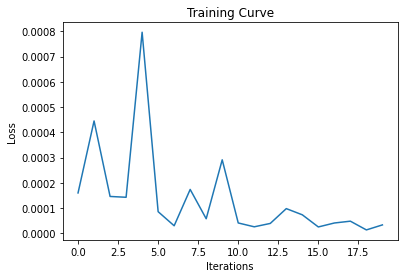

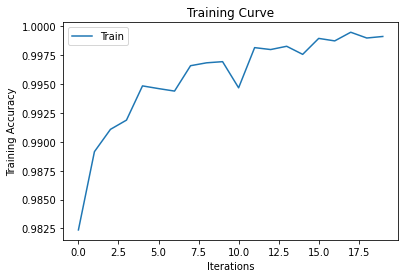

Final Training Accuracy: 0.9991333333333333
Training time:  200.23817372322083


In [ ]:
Net_train = train_only(trainloader_mnist, Net, batch_size=128, num_epochs=20, learning_rate=0.01)

In [ ]:
get_accuracy(Net_train, testloader_mnist)

0.9943

In [ ]:
with torch.cuda.device(0):
  macs, params = get_model_complexity_info(Net, (1, 28, 28), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

ConvNet(
  317.71 k, 100.000% Params, 49.25 MMac, 100.000% MACs, 
  (features): Sequential(
    297.22 k, 93.551% Params, 49.23 MMac, 99.958% MACs, 
    (0): Conv2d(1.28 k, 0.403% Params, 1.31 MMac, 2.662% MACs, 1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3))
    (1): GroupNorm(256, 0.081% Params, 262.14 KMac, 0.532% MACs, 128, 128, eps=1e-05, affine=True)
    (2): ReLU(0, 0.000% Params, 131.07 KMac, 0.266% MACs, inplace=True)
    (3): AvgPool2d(0, 0.000% Params, 131.07 KMac, 0.266% MACs, kernel_size=2, stride=2, padding=0)
    (4): Conv2d(147.58 k, 46.453% Params, 37.78 MMac, 76.720% MACs, 128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): GroupNorm(256, 0.081% Params, 65.54 KMac, 0.133% MACs, 128, 128, eps=1e-05, affine=True)
    (6): ReLU(0, 0.000% Params, 32.77 KMac, 0.067% MACs, inplace=True)
    (7): AvgPool2d(0, 0.000% Params, 32.77 KMac, 0.067% MACs, kernel_size=2, stride=2, padding=0)
    (8): Conv2d(147.58 k, 46.453% Params, 9.45 MMac, 19.180% MA

##CIFAR10

In [7]:
channel_cifar, im_size_cifar, num_classes_cifar, class_names_cifar, mean_cifar, std_cifar, dst_train_cifar, dst_test_cifar, testloader_cifar = get_dataset('CIFAR10', './../data')
# num_classes, dst_train, dst_test
images_all = []
labels_all = []
indices_class = [[] for c in range(num_classes_cifar)]

images_all = [torch.unsqueeze(dst_train_cifar[i][0], dim=0) for i in range(len(dst_train_cifar))]
labels_all = [dst_train_cifar[i][1] for i in range(len(dst_train_cifar))]
for i, lab in enumerate(labels_all):
    indices_class[lab].append(i)
images_all = torch.cat(images_all, dim=0).to('cuda')
labels_all = torch.tensor(labels_all, dtype=torch.long, device='cuda')
trainloader_cifar = torch.utils.data.DataLoader(TensorDataset(images_all, labels_all), batch_size=256, shuffle=True, num_workers=0)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./../data/cifar-10-python.tar.gz to ./../data
Files already downloaded and verified


In [ ]:
Net = get_network('ConvNet', channel_cifar, num_classes_cifar, im_size=im_size_cifar)

Epoch:  0 ; train acc:  0.62326 ; train loss:  0.9923944473266602
Epoch:  1 ; train acc:  0.70292 ; train loss:  0.8208551406860352
Epoch:  2 ; train acc:  0.73752 ; train loss:  0.9219017028808594
Epoch:  3 ; train acc:  0.77482 ; train loss:  0.8205684423446655
Epoch:  4 ; train acc:  0.78418 ; train loss:  0.6033849716186523
Epoch:  5 ; train acc:  0.82584 ; train loss:  0.6314994692802429
Epoch:  6 ; train acc:  0.83378 ; train loss:  0.5033170580863953
Epoch:  7 ; train acc:  0.85822 ; train loss:  0.5090145468711853
Epoch:  8 ; train acc:  0.87304 ; train loss:  0.4156133234500885
Epoch:  9 ; train acc:  0.8791 ; train loss:  0.4174838662147522
Epoch:  10 ; train acc:  0.89832 ; train loss:  0.5058808922767639
Epoch:  11 ; train acc:  0.89872 ; train loss:  0.4167826175689697
Epoch:  12 ; train acc:  0.92394 ; train loss:  0.48741236329078674
Epoch:  13 ; train acc:  0.92168 ; train loss:  0.26634103059768677
Epoch:  14 ; train acc:  0.92646 ; train loss:  0.18700619041919708
Epo

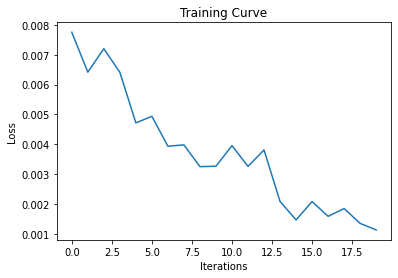

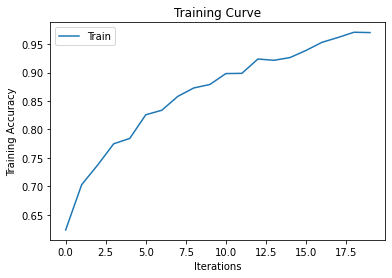

Final Training Accuracy: 0.97046
Training time:  169.77886128425598


In [ ]:
Net_trained = train_only(trainloader_cifar, Net, batch_size=128, num_epochs=20, learning_rate=0.01)

In [ ]:
get_accuracy(Net_trained, testloader_cifar)

0.7875

#Gradient Matching

##Training with synthetic data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import random
import matplotlib.pyplot as plt

###MNIST

In [ ]:
mnist_syn_dict = torch.load('/content/drive/MyDrive/ECE1512/ProjectB/All_Code/result/1000iterMNIST/res_DC_MNIST_LeNet_10ipc.pt')
minst_syn_data = tf.convert_to_tensor(mnist_syn_dict['data'][0][0])
minst_syn_label = tf.convert_to_tensor(mnist_syn_dict['data'][0][1])
minst_syn_data = torch.from_numpy(np.array(minst_syn_data))
minst_syn_label = torch.from_numpy(np.array(minst_syn_label))
trainloader_mnist_syn = torch.utils.data.DataLoader(TensorDataset(minst_syn_data, minst_syn_label), batch_size=256, shuffle=True, num_workers=0)

train group tensor(0)


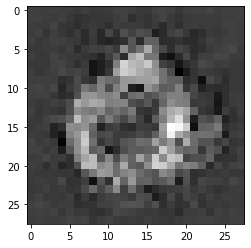

In [ ]:
index = random.randint(1, 99)
img=minst_syn_data[index].reshape(28,28)
plt.imshow(img,cmap='gray')
print('train group',minst_syn_label[index])

In [ ]:
Net = get_network('ConvNet', channel_mnist, num_classes_mnist, im_size=im_size_mnist)

Epoch:  0 ; train acc:  0.16 ; train loss:  2.3377277851104736
Epoch:  1 ; train acc:  0.32 ; train loss:  2.2620911598205566
Epoch:  2 ; train acc:  0.41 ; train loss:  2.167433023452759
Epoch:  3 ; train acc:  0.54 ; train loss:  2.0538482666015625
Epoch:  4 ; train acc:  0.61 ; train loss:  1.9213111400604248
Epoch:  5 ; train acc:  0.61 ; train loss:  1.7982139587402344
Epoch:  6 ; train acc:  0.72 ; train loss:  1.6874231100082397
Epoch:  7 ; train acc:  0.68 ; train loss:  1.5729278326034546
Epoch:  8 ; train acc:  0.71 ; train loss:  1.4640823602676392
Epoch:  9 ; train acc:  0.73 ; train loss:  1.3666497468948364
Epoch:  10 ; train acc:  0.78 ; train loss:  1.2712956666946411
Epoch:  11 ; train acc:  0.8 ; train loss:  1.1795947551727295
Epoch:  12 ; train acc:  0.82 ; train loss:  1.0954689979553223
Epoch:  13 ; train acc:  0.86 ; train loss:  1.0139669179916382
Epoch:  14 ; train acc:  0.88 ; train loss:  0.932401716709137
Epoch:  15 ; train acc:  0.88 ; train loss:  0.855656

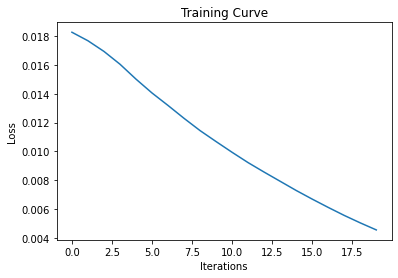

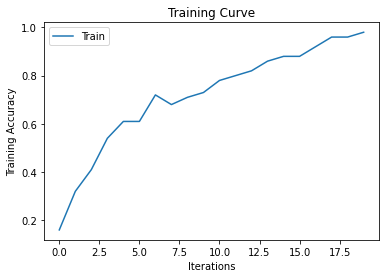

Final Training Accuracy: 0.98
Training time:  0.4772634506225586


In [ ]:
Net_train_syn = train_only(trainloader_mnist_syn, Net, batch_size=128, num_epochs=20, learning_rate=0.01)

In [ ]:
get_accuracy(Net_train_syn, testloader_mnist)

0.8791

###CIFAR10

In [ ]:
mnist_syn_dict = torch.load('/content/drive/MyDrive/ECE1512/ProjectB/All_Code/result/1000iterCIFAR10/res_DC_CIFAR10_LeNet_10ipc.pt')
minst_syn_data = tf.convert_to_tensor(mnist_syn_dict['data'][0][0])
minst_syn_label = tf.convert_to_tensor(mnist_syn_dict['data'][0][1])
minst_syn_data = torch.from_numpy(np.array(minst_syn_data))
minst_syn_label = torch.from_numpy(np.array(minst_syn_label))
trainloader_cifar_syn = torch.utils.data.DataLoader(TensorDataset(minst_syn_data, minst_syn_label), batch_size=256, shuffle=True, num_workers=0)

In [ ]:
Net = get_network('ConvNet', channel_cifar, num_classes_cifar, im_size=im_size_cifar)

Epoch:  0 ; train acc:  0.19 ; train loss:  2.3192200660705566
Epoch:  1 ; train acc:  0.29 ; train loss:  2.254890203475952
Epoch:  2 ; train acc:  0.35 ; train loss:  2.1575088500976562
Epoch:  3 ; train acc:  0.46 ; train loss:  2.0502543449401855
Epoch:  4 ; train acc:  0.51 ; train loss:  1.941484808921814
Epoch:  5 ; train acc:  0.66 ; train loss:  1.8295000791549683
Epoch:  6 ; train acc:  0.71 ; train loss:  1.7142280340194702
Epoch:  7 ; train acc:  0.79 ; train loss:  1.6022874116897583
Epoch:  8 ; train acc:  0.83 ; train loss:  1.4943279027938843
Epoch:  9 ; train acc:  0.88 ; train loss:  1.3880047798156738
Epoch:  10 ; train acc:  0.93 ; train loss:  1.2799944877624512
Epoch:  11 ; train acc:  0.95 ; train loss:  1.1714777946472168
Epoch:  12 ; train acc:  0.96 ; train loss:  1.0684417486190796
Epoch:  13 ; train acc:  0.97 ; train loss:  0.9696207642555237
Epoch:  14 ; train acc:  0.97 ; train loss:  0.8726722598075867
Epoch:  15 ; train acc:  1.0 ; train loss:  0.779403

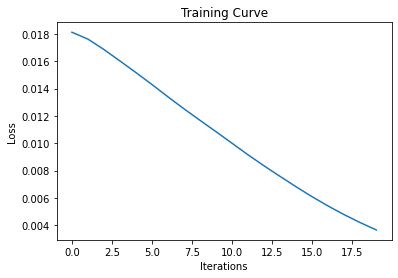

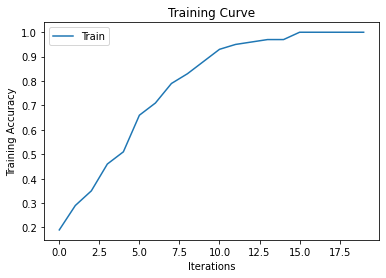

Final Training Accuracy: 1.0
Training time:  0.49994730949401855


In [ ]:
Net_train_syn_cifar = train_only(trainloader_cifar_syn, Net, batch_size=128, num_epochs=20, learning_rate=0.01)

In [ ]:
get_accuracy(Net_train_syn_cifar, testloader_cifar)

0.3299

##Cross-Validation

###MNIST


In [ ]:
net = get_network('VGG11', channel_mnist, num_classes_mnist, im_size=im_size_mnist)

Epoch:  0 ; train acc:  0.15 ; train loss:  2.488028049468994
Epoch:  1 ; train acc:  0.22 ; train loss:  2.281198501586914
Epoch:  2 ; train acc:  0.35 ; train loss:  2.3684096336364746
Epoch:  3 ; train acc:  0.14 ; train loss:  2.2376608848571777
Epoch:  4 ; train acc:  0.13 ; train loss:  2.1411569118499756
Epoch:  5 ; train acc:  0.64 ; train loss:  2.1171817779541016
Epoch:  6 ; train acc:  0.59 ; train loss:  2.054975986480713
Epoch:  7 ; train acc:  0.57 ; train loss:  2.0070314407348633
Epoch:  8 ; train acc:  0.79 ; train loss:  1.9382905960083008
Epoch:  9 ; train acc:  0.65 ; train loss:  1.8706297874450684
Epoch:  10 ; train acc:  0.82 ; train loss:  1.7566674947738647
Epoch:  11 ; train acc:  0.77 ; train loss:  1.6785986423492432
Epoch:  12 ; train acc:  0.82 ; train loss:  1.5837864875793457
Epoch:  13 ; train acc:  0.85 ; train loss:  1.4467346668243408
Epoch:  14 ; train acc:  0.94 ; train loss:  1.2904939651489258
Epoch:  15 ; train acc:  0.94 ; train loss:  1.172521

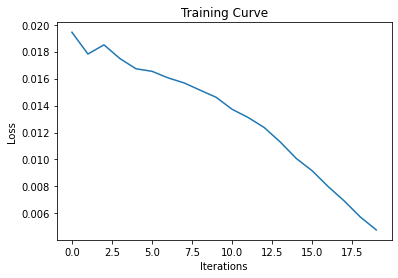

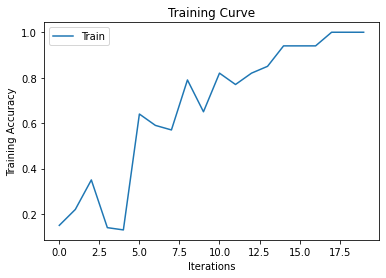

Final Training Accuracy: 1.0
Training time:  0.8900847434997559


In [ ]:
net_train_syn = train_only(trainloader_mnist_syn, net, batch_size=128, num_epochs=20, learning_rate=0.01)

In [ ]:
get_accuracy(net_train_syn, testloader_mnist)

0.8297

###CIFAR10

In [ ]:
net = get_network('VGG11', channel_cifar, num_classes_cifar, im_size=im_size_cifar)

Epoch:  0 ; train acc:  0.32 ; train loss:  2.600874662399292
Epoch:  1 ; train acc:  0.26 ; train loss:  2.2016501426696777
Epoch:  2 ; train acc:  0.11 ; train loss:  2.212559461593628
Epoch:  3 ; train acc:  0.69 ; train loss:  2.1184253692626953
Epoch:  4 ; train acc:  0.57 ; train loss:  2.0105462074279785
Epoch:  5 ; train acc:  1.0 ; train loss:  1.936794400215149
Epoch:  6 ; train acc:  0.93 ; train loss:  1.807915210723877
Epoch:  7 ; train acc:  1.0 ; train loss:  1.6953577995300293
Epoch:  8 ; train acc:  0.99 ; train loss:  1.5553125143051147
Epoch:  9 ; train acc:  1.0 ; train loss:  1.432620882987976
Epoch:  10 ; train acc:  1.0 ; train loss:  1.2773493528366089
Epoch:  11 ; train acc:  1.0 ; train loss:  1.1058286428451538
Epoch:  12 ; train acc:  1.0 ; train loss:  0.93748939037323
Epoch:  13 ; train acc:  1.0 ; train loss:  0.7611737251281738
Epoch:  14 ; train acc:  1.0 ; train loss:  0.6070466041564941
Epoch:  15 ; train acc:  1.0 ; train loss:  0.48488593101501465
E

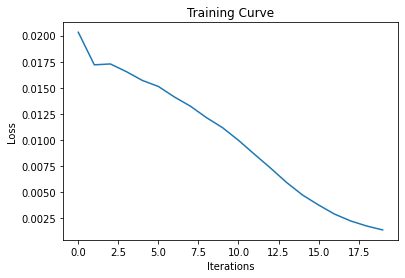

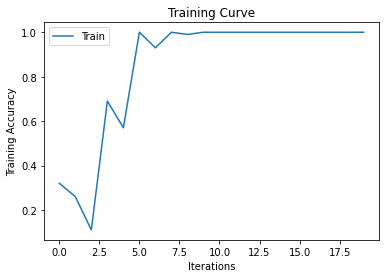

Final Training Accuracy: 1.0
Training time:  0.8947956562042236


In [ ]:
net_train_syn = train_only(trainloader_cifar_syn, net, batch_size=128, num_epochs=20, learning_rate=0.01)

In [ ]:
get_accuracy(net_train_syn, testloader_cifar)

0.2784

##Continue Learning

In [ ]:
%cd /content/drive/MyDrive/ECE1512/ProjectB/All_Code

/content/drive/MyDrive/ECE1512/ProjectB/All_Code


In [ ]:
!python CL_DM.py


method:  default
seed:  0
class_order:  [2, 8, 4, 9, 1, 6, 7, 3, 0, 5]
augmentation strategy: 
 color_crop_cutout_flip_scale_rotate
augmentation parameters: 
 {'aug_mode': 'S', 'prob_flip': 0.5, 'ratio_scale': 1.2, 'ratio_rotate': 15.0, 'ratio_crop_pad': 0.125, 'ratio_cutout': 0.5, 'brightness': 1.0, 'saturation': 2.0, 'contrast': 0.5}
use data: MNIST

-----------------------------
method default seed 0 step 0 
classes_seen:  [2, 8]
train data size:  torch.Size([100, 1, 28, 28])
test set size:  torch.Size([2006, 1, 28, 28])
Model continute learn [2, 8] classes and evaluate on 3 random network. The average test accuracy is 0.6837819873712196

-----------------------------
method default seed 0 step 1 
classes_seen:  [2, 8, 4, 9]
train data size:  torch.Size([100, 1, 28, 28])
test set size:  torch.Size([3997, 1, 28, 28])
Model continute learn [2, 8, 4, 9] classes and evaluate on 3 random network. The average test accuracy is 0.788091068301226

-----------------------------
method defaul

#Trajectories Matching

##Testing the Synthetic Dataset generated by researchers on CIFAR10 dataset

https://georgecazenavette.github.io/mtt-distillation/tensors/index.html#tensors

In [ ]:
minst_syn_data = tf.convert_to_tensor(torch.load('/content/drive/MyDrive/ECE1512/ProjectB/Matching_Traj/images_best.pt'))
minst_syn_label = tf.convert_to_tensor(torch.load('/content/drive/MyDrive/ECE1512/ProjectB/Matching_Traj/labels_best.pt'))
minst_syn_data = torch.from_numpy(np.array(minst_syn_data))
minst_syn_label = torch.from_numpy(np.array(minst_syn_label))
trainloader_cifar_syn = torch.utils.data.DataLoader(TensorDataset(minst_syn_data, minst_syn_label), batch_size=256, shuffle=True, num_workers=0)

In [ ]:
Net = get_network('ConvNet', channel_cifar, num_classes_cifar, im_size=im_size_cifar)

Epoch:  0 ; train acc:  0.18 ; train loss:  2.327756881713867
Epoch:  1 ; train acc:  0.28 ; train loss:  2.280228614807129
Epoch:  2 ; train acc:  0.33 ; train loss:  2.217180013656616
Epoch:  3 ; train acc:  0.49 ; train loss:  2.150261163711548
Epoch:  4 ; train acc:  0.56 ; train loss:  2.0700571537017822
Epoch:  5 ; train acc:  0.83 ; train loss:  1.9707651138305664
Epoch:  6 ; train acc:  0.93 ; train loss:  1.8630270957946777
Epoch:  7 ; train acc:  0.89 ; train loss:  1.7616156339645386
Epoch:  8 ; train acc:  0.91 ; train loss:  1.6698516607284546
Epoch:  9 ; train acc:  0.99 ; train loss:  1.5761849880218506
Epoch:  10 ; train acc:  0.99 ; train loss:  1.474348783493042
Epoch:  11 ; train acc:  0.99 ; train loss:  1.3713513612747192
Epoch:  12 ; train acc:  0.99 ; train loss:  1.2750558853149414
Epoch:  13 ; train acc:  0.99 ; train loss:  1.1827243566513062
Epoch:  14 ; train acc:  0.99 ; train loss:  1.088908076286316
Epoch:  15 ; train acc:  1.0 ; train loss:  0.9929000735

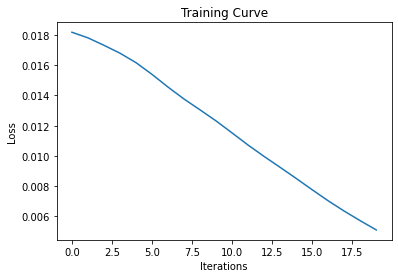

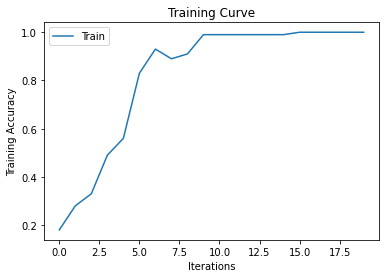

Final Training Accuracy: 1.0
Training time:  0.5112988948822021


In [ ]:
Net_train_syn_cifar = train_only(trainloader_cifar_syn, Net, batch_size=128, num_epochs=20, learning_rate=0.01)

In [30]:
get_accuracy(Net_train_syn_cifar, testloader_cifar)

0.3178

##Training with synthetic data

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import tensorflow as tf
import random
import matplotlib.pyplot as plt

###MNIST

In [ ]:
mnist_syn_dict = torch.load('/content/drive/MyDrive/ECE1512/ProjectB/Matching_Traj/mtt-distillation-main/results/buffer10/real/res_MNIST_ConvNet_10ipc.pt')
minst_syn_data = tf.convert_to_tensor(mnist_syn_dict['data'][0][0])
minst_syn_label = tf.convert_to_tensor(mnist_syn_dict['data'][0][1])
minst_syn_data = torch.from_numpy(np.array(minst_syn_data))
minst_syn_label = torch.from_numpy(np.array(minst_syn_label))
trainloader_mnist_syn = torch.utils.data.DataLoader(TensorDataset(minst_syn_data, minst_syn_label), batch_size=256, shuffle=True, num_workers=0)

train group tensor(7)


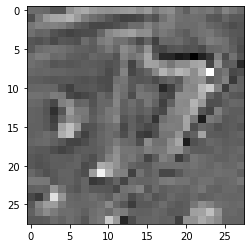

In [ ]:
index = random.randint(1, 99)
img=minst_syn_data[index].reshape(28,28)
plt.imshow(img,cmap='gray')
print('train group',minst_syn_label[index])

In [ ]:
Net = get_network('ConvNet', channel_mnist, num_classes_mnist, im_size=im_size_mnist)

Epoch:  0 ; train acc:  0.12 ; train loss:  2.3754818439483643
Epoch:  1 ; train acc:  0.22 ; train loss:  2.310957908630371
Epoch:  2 ; train acc:  0.24 ; train loss:  2.2277560234069824
Epoch:  3 ; train acc:  0.39 ; train loss:  2.141603946685791
Epoch:  4 ; train acc:  0.72 ; train loss:  2.0351738929748535
Epoch:  5 ; train acc:  0.9 ; train loss:  1.9069637060165405
Epoch:  6 ; train acc:  0.88 ; train loss:  1.781653642654419
Epoch:  7 ; train acc:  0.89 ; train loss:  1.672633171081543
Epoch:  8 ; train acc:  0.95 ; train loss:  1.5648105144500732
Epoch:  9 ; train acc:  0.97 ; train loss:  1.4463140964508057
Epoch:  10 ; train acc:  0.98 ; train loss:  1.3286651372909546
Epoch:  11 ; train acc:  0.99 ; train loss:  1.220970869064331
Epoch:  12 ; train acc:  1.0 ; train loss:  1.1158525943756104
Epoch:  13 ; train acc:  1.0 ; train loss:  1.0062384605407715
Epoch:  14 ; train acc:  1.0 ; train loss:  0.8979411125183105
Epoch:  15 ; train acc:  1.0 ; train loss:  0.7983638048171

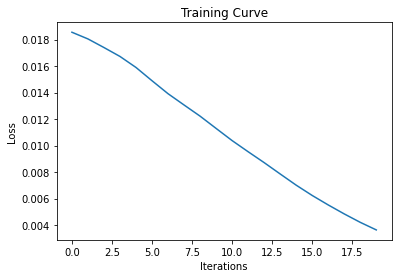

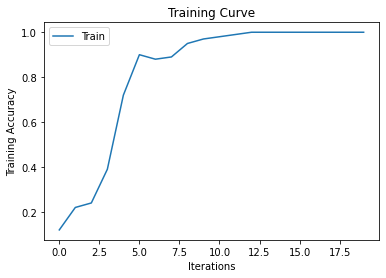

Final Training Accuracy: 1.0
Training time:  0.45625758171081543


In [ ]:
Net_train_syn = train_only(trainloader_mnist_syn, Net, batch_size=128, num_epochs=20, learning_rate=0.01)

In [ ]:
get_accuracy(Net_train_syn, testloader_mnist)  #VGG 0.5 VGGBN 0.582

0.5492

###CIFAR10

In [ ]:
mnist_syn_dict = torch.load('/content/drive/MyDrive/ECE1512/ProjectB/Matching_Traj/mtt-distillation-main/results/res_CIFAR10_ConvNet_10ipc.pt')
minst_syn_data = tf.convert_to_tensor(mnist_syn_dict['data'][0][0])
minst_syn_label = tf.convert_to_tensor(mnist_syn_dict['data'][0][1])
minst_syn_data = torch.from_numpy(np.array(minst_syn_data))
minst_syn_label = torch.from_numpy(np.array(minst_syn_label))
trainloader_cifar_syn = torch.utils.data.DataLoader(TensorDataset(minst_syn_data, minst_syn_label), batch_size=256, shuffle=True, num_workers=0)

In [ ]:
Net = get_network('ConvNet', channel_cifar, num_classes_cifar, im_size=im_size_cifar)

Epoch:  0 ; train acc:  0.14 ; train loss:  2.3511507511138916
Epoch:  1 ; train acc:  0.18 ; train loss:  2.3063061237335205
Epoch:  2 ; train acc:  0.25 ; train loss:  2.244077682495117
Epoch:  3 ; train acc:  0.36 ; train loss:  2.179243564605713
Epoch:  4 ; train acc:  0.48 ; train loss:  2.1049234867095947
Epoch:  5 ; train acc:  0.77 ; train loss:  2.0110533237457275
Epoch:  6 ; train acc:  0.94 ; train loss:  1.9038188457489014
Epoch:  7 ; train acc:  0.95 ; train loss:  1.799815058708191
Epoch:  8 ; train acc:  0.96 ; train loss:  1.7057493925094604
Epoch:  9 ; train acc:  0.98 ; train loss:  1.6132701635360718
Epoch:  10 ; train acc:  1.0 ; train loss:  1.5140540599822998
Epoch:  11 ; train acc:  1.0 ; train loss:  1.4106380939483643
Epoch:  12 ; train acc:  1.0 ; train loss:  1.3106995820999146
Epoch:  13 ; train acc:  1.0 ; train loss:  1.215950846672058
Epoch:  14 ; train acc:  1.0 ; train loss:  1.1212769746780396
Epoch:  15 ; train acc:  1.0 ; train loss:  1.0239222049713

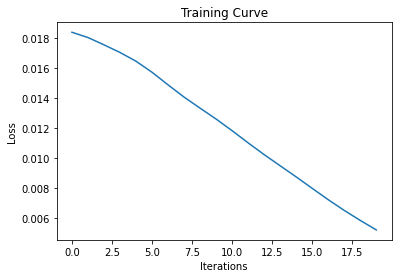

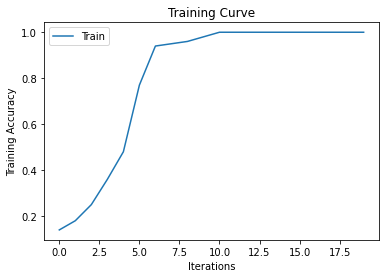

Final Training Accuracy: 1.0
Training time:  0.4811112880706787


In [ ]:
Net_train_syn_cifar = train_only(trainloader_cifar_syn, Net, batch_size=128, num_epochs=20, learning_rate=0.01)

In [ ]:
get_accuracy(Net_train_syn_cifar, testloader_cifar)

0.2281

##Cross Validation

###MNIST

In [ ]:
net = get_network('ResNet18BN_AP', channel_mnist, num_classes_mnist, im_size=im_size_mnist)

Epoch:  0 ; train acc:  0.37 ; train loss:  2.564103603363037
Epoch:  1 ; train acc:  0.5 ; train loss:  2.459981918334961
Epoch:  2 ; train acc:  0.65 ; train loss:  2.496328592300415
Epoch:  3 ; train acc:  0.58 ; train loss:  2.3048229217529297
Epoch:  4 ; train acc:  0.86 ; train loss:  2.1391172409057617
Epoch:  5 ; train acc:  0.96 ; train loss:  0.44792288541793823
Epoch:  6 ; train acc:  0.78 ; train loss:  0.18591472506523132
Epoch:  7 ; train acc:  1.0 ; train loss:  0.5788112282752991
Epoch:  8 ; train acc:  0.99 ; train loss:  0.01267369743436575
Epoch:  9 ; train acc:  0.99 ; train loss:  0.052034225314855576
Epoch:  10 ; train acc:  1.0 ; train loss:  0.052460744976997375
Epoch:  11 ; train acc:  1.0 ; train loss:  0.024952581152319908
Epoch:  12 ; train acc:  1.0 ; train loss:  0.019575053825974464
Epoch:  13 ; train acc:  1.0 ; train loss:  0.010614159516990185
Epoch:  14 ; train acc:  1.0 ; train loss:  0.004389239940792322
Epoch:  15 ; train acc:  1.0 ; train loss:  0

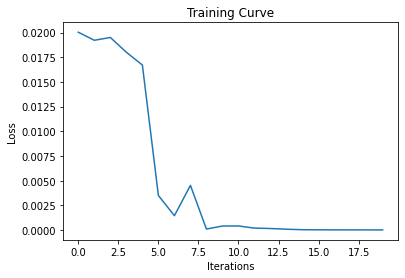

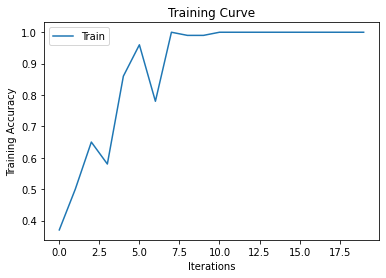

Final Training Accuracy: 1.0
Training time:  2.405195713043213


In [ ]:
net_train_syn = train_only(trainloader_mnist_syn, net, batch_size=128, num_epochs=20, learning_rate=0.01)

In [ ]:
get_accuracy(net_train_syn, testloader_mnist)

0.5054

###CIFAR10

In [ ]:
net = get_network('VGG11', channel_cifar, num_classes_cifar, im_size=im_size_cifar)

Epoch:  0 ; train acc:  0.27 ; train loss:  2.5883257389068604
Epoch:  1 ; train acc:  0.27 ; train loss:  2.2736611366271973
Epoch:  2 ; train acc:  0.35 ; train loss:  2.327941417694092
Epoch:  3 ; train acc:  0.68 ; train loss:  2.248178482055664
Epoch:  4 ; train acc:  0.6 ; train loss:  2.0911333560943604
Epoch:  5 ; train acc:  0.12 ; train loss:  1.9968438148498535
Epoch:  6 ; train acc:  0.91 ; train loss:  1.9495763778686523
Epoch:  7 ; train acc:  0.9 ; train loss:  1.8465980291366577
Epoch:  8 ; train acc:  1.0 ; train loss:  1.74843168258667
Epoch:  9 ; train acc:  1.0 ; train loss:  1.6169624328613281
Epoch:  10 ; train acc:  1.0 ; train loss:  1.4726319313049316
Epoch:  11 ; train acc:  1.0 ; train loss:  1.3208346366882324
Epoch:  12 ; train acc:  1.0 ; train loss:  1.1409251689910889
Epoch:  13 ; train acc:  1.0 ; train loss:  0.9725794792175293
Epoch:  14 ; train acc:  1.0 ; train loss:  0.799530029296875
Epoch:  15 ; train acc:  1.0 ; train loss:  0.6422321796417236
E

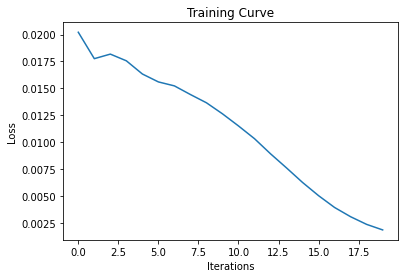

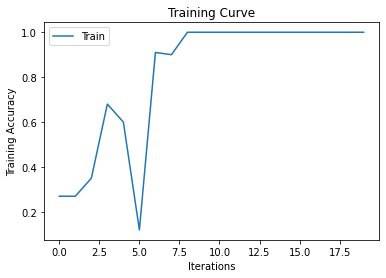

Final Training Accuracy: 1.0
Training time:  0.9493541717529297


In [ ]:
net_train_syn = train_only(trainloader_cifar_syn, net, batch_size=128, num_epochs=20, learning_rate=0.01)

In [ ]:
get_accuracy(net_train_syn, testloader_cifar)

0.2923

##Continue Learning

In [ ]:
%cd /content/drive/MyDrive/ECE1512/ProjectB/All_Code

/content/drive/MyDrive/ECE1512/ProjectB/All_Code


In [ ]:
!python CL_DM.py \
    --syn_data_path '/content/drive/MyDrive/ECE1512/ProjectB/Matching_Traj/mtt-distillation-main/results/buffer10/real/res_MNIST_ConvNet_10ipc.pt'


method:  default
seed:  0
class_order:  [2, 8, 4, 9, 1, 6, 7, 3, 0, 5]
augmentation strategy: 
 color_crop_cutout_flip_scale_rotate
augmentation parameters: 
 {'aug_mode': 'S', 'prob_flip': 0.5, 'ratio_scale': 1.2, 'ratio_rotate': 15.0, 'ratio_crop_pad': 0.125, 'ratio_cutout': 0.5, 'brightness': 1.0, 'saturation': 2.0, 'contrast': 0.5}
use data: MNIST

-----------------------------
method default seed 0 step 0 
classes_seen:  [2, 8]
train data size:  torch.Size([100, 1, 28, 28])
test set size:  torch.Size([2006, 1, 28, 28])
Model continute learn [2, 8] classes and evaluate on 3 random network. The average test accuracy is 0.9199069458291792

-----------------------------
method default seed 0 step 1 
classes_seen:  [2, 8, 4, 9]
train data size:  torch.Size([100, 1, 28, 28])
test set size:  torch.Size([3997, 1, 28, 28])
Model continute learn [2, 8, 4, 9] classes and evaluate on 3 random network. The average test accuracy is 0.7468935034609291

-----------------------------
method defau